In [1]:
import os
import sys

MODULE_PATH = '/content/drive/MyDrive/GitHub/DL_Study/Base'

sys.path.insert(0, MODULE_PATH)
sys.path

['/content/drive/MyDrive/GitHub/DL_Study/Base',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [2]:
# import
import numpy
from config import *
from optim import Adam
from models import CnnModelReg

# for time series split
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
# configuration setting
def model_config():
    # parameter for CNN Model
    filter_num = [30]
    filter_size = [3]
    epochs = [30]
    batch_size = [64]
    learning_rate = [0.01, 0.001]
    
    # create config data
    configs = []
    for i in filter_num:
        for j in filter_size:
            for k in epochs:
                for l in batch_size:
                    for m in learning_rate:
                        config = [i, j, k, l, m]
                        configs.append(config)
    return configs

# fucntion for fit cnn model using configs
def model_fit(train_X, train_y, config):
    # unpack config
    n_filter, n_fsize, n_epochs, n_batch, learning_rate = config
    cnn_params = {'filter_num':n_filter, 'filter_size':n_fsize, 
                  'stride':1, 'padding':0}
    model = CnnModelReg(input_dim=(1, 24, 18),params=cnn_params)
    # fit model and return
    model.fit(train_X=train_X, train_y=train_y, epochs=n_epochs, 
              batch_size=n_batch, learning_rate=learning_rate)
    return model

def MAE_metric(x, t):
    t = np.array(t)
    return np.mean(numpy.abs(x-t))

def MSE_metric(x, t):
    t = np.array(t)
    return np.mean((x-t)**2)

In [4]:
# dataset
import zipfile, requests, io
import pandas as pd
import numpy
import time
from datetime import datetime

numpy.random.seed(42)
np.random.seed(42)

df_parser = lambda x: datetime.strptime(x, '%d/%m/%Y %H.%M.%S')
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00274/NEW-DATA.zip'
r = requests.get(data_url)
files = zipfile.ZipFile(io.BytesIO(r.content))
df = pd.concat(
    [pd.read_csv(files.open(i), sep=' ') for i in files.namelist()]
)
cols = df.columns.tolist()
cols = cols[2:]+cols[:2]
df.columns = cols
df.drop(df.columns[[0, 1, 18, 19, 20, 24, 25]], axis = 1, inplace=True)
df.drop(columns=df.columns[[1]], axis=1, inplace=True)      # for target column 3
df.head()

,3:Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,18.1875,0.0,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,623.360,1.42625,9690.24,12604.20,95436.8,758.880,18.1150,48.3750,2.0
1,18.4633,6.8,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.00,10787.20,95436.8,762.069,18.4147,47.8080,2.0
2,18.7673,17.0,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,622.656,1.89133,13960.50,9669.63,95398.6,766.251,18.8533,47.4320,2.0
3,19.0727,18.0,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,622.571,1.82800,18511.20,9648.13,95360.3,766.037,19.2907,47.0240,2.0
4,19.3721,20.0,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,622.400,2.36071,26349.00,9208.32,95354.9,762.743,19.7400,45.4743,2.0


In [5]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller

# jb = (n/6)*(skewness**2 + (kurtosis**2/4))

def data_statistics(df):
    df = df.dropna()
    data = df.values
    num = len(df)
    skewness_ = skew(data)
    kurtosis_ = kurtosis(data)
    jarque_bera_ = (num/6)*(skewness_**2 + (kurtosis_**2/4))
    result = adfuller(data)
    adf_ = result[0]
    print(f'skewness : {skewness_}')
    print(f'kurtosis : {kurtosis_}')
    print(f'jarque bera : {jarque_bera_}')
    print(f'ADF : {adf_}')

data_statistics(df['3:Temperature_Comedor_Sensor'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


skewness : -0.16979917549275816
kurtosis : -0.10533904114168946
jarque bera : 21.79222557347876
ADF : -4.314742594943982


In [6]:
df.describe()

,3:Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
count,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000
mean,20.493530,15.092676,206.599835,209.611623,42.389879,44.546069,28.970248,42.335496,0.038756,335.094312,1.304623,14749.149509,13566.284958,19857.184071,232.203649,18.019331,53.251632,3.962549
std,3.312096,4.375374,22.763114,24.183477,7.215405,8.297436,25.684356,42.602571,0.187128,304.513038,1.223829,25306.450482,23311.852941,29494.598354,312.460713,4.285242,13.511063,1.988923
min,11.352000,0.000000,187.339000,188.907000,26.173300,27.256000,10.740000,11.328000,0.000000,0.606667,0.000000,0.000000,0.000000,0.000000,-4.164670,9.223330,22.246700,1.000000
25%,18.424600,12.000000,200.228000,201.707000,36.088000,38.446700,11.540700,13.509300,0.000000,0.650000,0.168667,0.000000,0.000000,0.000000,-3.250670,14.903300,42.650700,2.000000
50%,20.499300,15.000000,205.131000,208.907000,42.776000,44.802700,14.126700,22.085300,0.000000,612.821000,0.962667,752.640000,1025.020000,645.120000,11.246000,17.734700,54.717300,4.000000
75%,22.865300,18.000000,210.016000,212.331000,47.584000,50.301300,40.034700,55.064000,0.000000,619.712000,2.225330,14627.500000,12907.200000,33263.600000,479.552000,20.888000,63.128000,6.000000
max,28.924000,29.000000,594.389000,609.237000,60.957300,62.594700,111.797000,162.965000,1.000000,625.003000,6.321330,95278.400000,92367.500000,95704.400000,1094.660000,29.908000,83.805300,7.000000


In [7]:
df.isnull().sum()

3:Temperature_Comedor_Sensor      0
5:Weather_Temperature             0
6:CO2_Comedor_Sensor              0
7:CO2_Habitacion_Sensor           0
8:Humedad_Comedor_Sensor          0
9:Humedad_Habitacion_Sensor       0
10:Lighting_Comedor_Sensor        0
11:Lighting_Habitacion_Sensor     0
12:Precipitacion                  0
13:Meteo_Exterior_Crepusculo      0
14:Meteo_Exterior_Viento          0
15:Meteo_Exterior_Sol_Oest        0
16:Meteo_Exterior_Sol_Est         0
17:Meteo_Exterior_Sol_Sud         0
18:Meteo_Exterior_Piranometro     0
22:Temperature_Exterior_Sensor    0
23:Humedad_Exterior_Sensor        0
24:Day_Of_Week                    0
dtype: int64

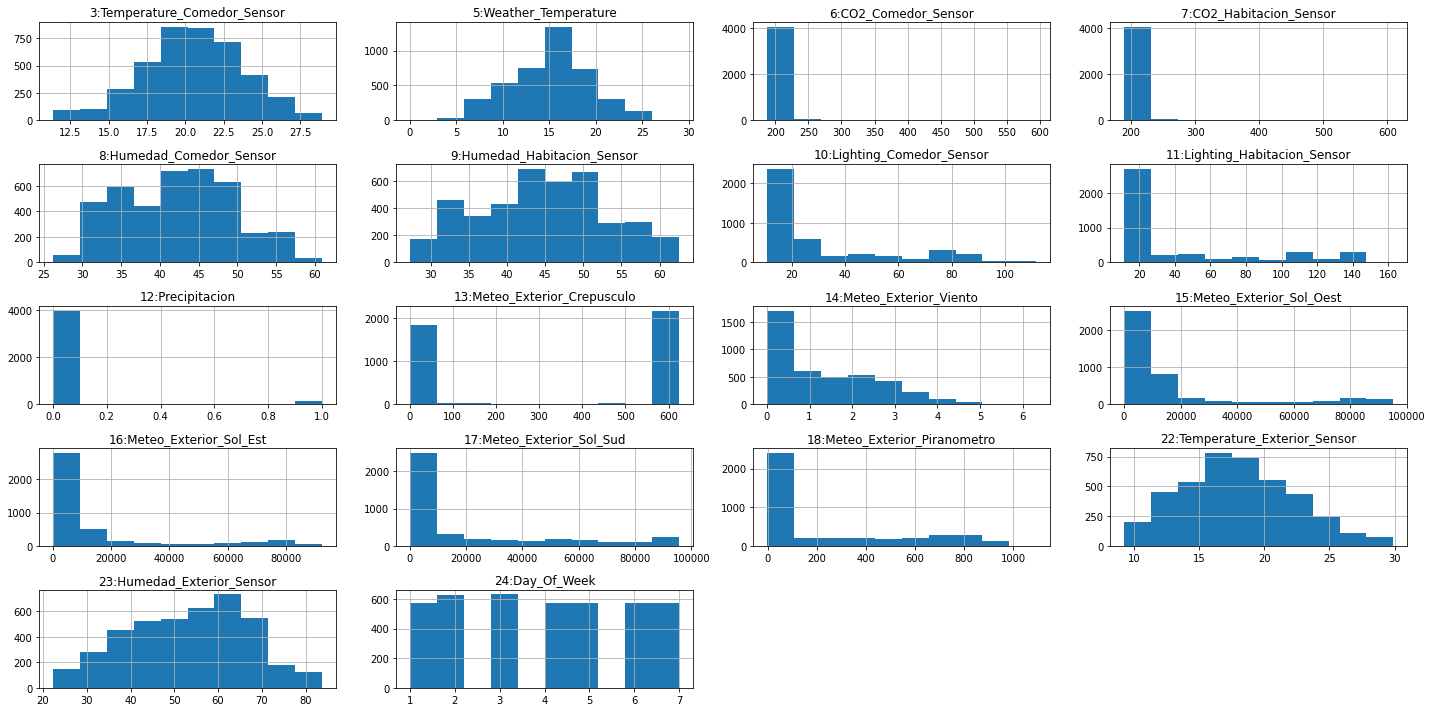

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

df.hist(figsize=(20, 10))
plt.tight_layout()
plt.show()

In [9]:
# series data to img function
def series_to_img(dataset, time_step=1):
    num = dataset.shape[1]      # features num
    df = pd.DataFrame(dataset)
    cols, names = list(), list()
    # sequence t-n to t-1
    for i in range(time_step, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num)]

    for i in range(0, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

dataset = df.values
dataset = dataset.astype('float')

n_inputs = 24
n_features = 18
del_idx = n_inputs * n_features + 1
del_cols = [i for i in range(del_idx, del_idx+n_features-1)]
new_df = series_to_img(dataset, n_inputs)
new_df.drop(new_df.columns[del_cols], axis=1, inplace=True)
new_df.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),var11(t-24),var12(t-24),var13(t-24),var14(t-24),var15(t-24),var16(t-24),var17(t-24),var18(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var5(t-23),var6(t-23),var7(t-23),var8(t-23),var9(t-23),var10(t-23),var11(t-23),var12(t-23),var13(t-23),var14(t-23),var15(t-23),var16(t-23),var17(t-23),var18(t-23),var1(t-22),var2(t-22),var3(t-22),var4(t-22),...,var16(t-3),var17(t-3),var18(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var1(t)
24,18.1875,0.0,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,623.360,1.42625,9690.24,12604.20,95436.8,758.880,18.1150,48.3750,2.0,18.4633,6.8,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.0,10787.20,95436.8,762.069,18.4147,47.8080,2.0,18.7673,17.0,219.403,218.933,...,20.4627,43.2747,2.0,21.8080,19.0000,212.064,216.672,40.8667,37.7867,20.8400,23.5853,0.0,617.109,1.544000,40424.40,4243.460,6537.220,101.24400,20.2047,43.6107,2.0,21.7680,18.6667,211.211,216.299,40.9813,37.7120,20.9207,23.2253,0.0,615.957,1.088670,3024.90,2229.250,2042.880,24.66530,19.9760,45.8293,2.0,21.7133
25,18.4633,6.8,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.00,10787.20,95436.8,762.069,18.4147,47.8080,2.0,18.7673,17.0,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,622.656,1.89133,13960.5,9669.63,95398.6,766.251,18.8533,47.4320,2.0,19.0727,18.0,218.613,217.045,...,20.2047,43.6107,2.0,21.7680,18.6667,211.211,216.299,40.9813,37.7120,20.9207,23.2253,0.0,615.957,1.088670,3024.90,2229.250,2042.880,24.66530,19.9760,45.8293,2.0,21.7133,18.0000,211.051,216.768,41.4107,37.7480,19.4407,23.2427,0.0,615.360,0.844667,2207.74,1576.960,1512.450,15.57000,19.7560,47.0693,2.0,21.6600
26,18.7673,17.0,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,622.656,1.89133,13960.50,9669.63,95398.6,766.251,18.8533,47.4320,2.0,19.0727,18.0,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,622.571,1.82800,18511.2,9648.13,95360.3,766.037,19.2907,47.0240,2.0,19.3721,20.0,217.714,216.080,...,19.9760,45.8293,2.0,21.7133,18.0000,211.051,216.768,41.4107,37.7480,19.4407,23.2427,0.0,615.360,0.844667,2207.74,1576.960,1512.450,15.57000,19.7560,47.0693,2.0,21.6600,18.0000,210.763,217.088,41.9920,37.8373,11.5887,21.4213,0.0,614.592,1.442000,1017.86,222.208,293.888,5.00933,19.5273,49.5467,2.0,21.5960
27,19.0727,18.0,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,622.571,1.82800,18511.20,9648.13,95360.3,766.037,19.2907,47.0240,2.0,19.3721,20.0,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,622.400,2.36071,26349.0,9208.32,95354.9,762.743,19.7400,45.4743,2.0,19.6407,20.0,218.389,216.011,...,19.7560,47.0693,2.0,21.6600,18.0000,210.763,217.088,41.9920,37.8373,11.5887,21.4213,0.0,614.592,1.442000,1017.86,222.208,293.888,5.00933,19.5273,49.5467,2.0,21.5960,18.0000,210.571,215.616,43.1973,38.2173,11.5073,13.3620,0.0,585.984,0.969333,0.00,0.000,0.000,-2.93933,19.3013,52.2027,2.0,21.5307
28,19.3721,20.0,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,622.400,2.36071,26349.00,9208.32,95354.9,762.743,19.7400,45.4743,2.0,19.6407,20.0,218.389,216.011,39.8107,42.0347,81.2427,113.600,0.0,622.400,2.06333,36511.7,8694.78,95354.9,752.683,20.1660,45.5467,2.0,19.9120,20.0,218.155,215.829,...,19.5273,49.5467,2.0,21.5960,18.0000,210.571,215.616,43.1973,38.2173,11.5073,13.3620,0.0,585.984,0.969333,0.00,0.000,0.000,-2.93933,19.3013,52.2027,2.0,21.5307,17.8667,209.920,216.107,43.8213,39.3560,11.5073,13.1027,0.0,150.851,0.798667,0.00,0.000,0.000,-3.90400,19.0413,53.8053,2.0,21.4493


In [10]:
n_splits = 3
test_size = (int)(len(new_df)*0.2)
train_test_split = TimeSeriesSplit(n_splits=n_splits+1, gap=n_inputs, test_size=test_size).split(new_df)
next(train_test_split)

configs = model_config()
history = []

best_rmse, best_mse, best_mae = [], [], []

i = 1

print('config : filter_num, filter_size, epochs, batch_size, learning_rate')

# nested cross validation for time series model
for train_cv_indices, test_cv_indices in train_test_split:
    print(f'fold : {i}/{n_splits}')
    i+=1

    # split x, y data
    train_cv_X, train_cv_y = new_df.iloc[train_cv_indices, :-1].values, new_df.iloc[train_cv_indices,-1].values
    test_cv_X, test_cv_y = new_df.iloc[test_cv_indices, :-1].values, new_df.iloc[test_cv_indices, -1].values

    # length for validation set
    test_length = len(test_cv_X)

    # scaling data
    scaler_x = MinMaxScaler()
    train_cv_X = scaler_x.fit_transform(train_cv_X)
    test_cv_X = scaler_x.transform(test_cv_X)

    train_X, val_X = train_cv_X[:-test_length, :], train_cv_X[-test_length:, :]
    train_y, val_y = train_cv_y[:-test_length], train_cv_y[-test_length:]

    # reshape
    # inner loop
    train_X = train_X.reshape(-1, 1, n_inputs, n_features)
    val_X = val_X.reshape(-1, 1, n_inputs, n_features)
    train_y = train_y.reshape(-1, 1)
    val_y = val_y.reshape(-1, 1)

    # outer loop
    train_cv_X = train_cv_X.reshape(-1, 1, n_inputs, n_features)
    test_cv_X = test_cv_X.reshape(-1, 1, n_inputs, n_features)
    train_cv_y = train_cv_y.reshape(-1, 1)
    test_cv_y = test_cv_y.reshape(-1, 1)

    # model fit, inner
    errors = []
    for idx, cfg in enumerate(configs):
        print(f' == train {cfg} model == ', end=' ')
        model = model_fit(train_X, train_y, cfg)
        predicted = model.predict(val_X)
        error = np.sqrt(MSE_metric(predicted, val_y))   # rmse
        print(f'error(rmse):{error.item():.2f}')
        if errors:
            if error < min(errors):
                param = idx
        else:
            param = idx
        errors.append(error)

    history.append(errors)

    # outer
    selected_model = model_fit(train_cv_X,train_cv_y, configs[param])
    predicted = selected_model.predict(test_cv_X)
    rmse = np.sqrt(MSE_metric(predicted, test_cv_y))
    mse = MSE_metric(predicted, test_cv_y)
    mae = MAE_metric(predicted, test_cv_y)
    best_rmse.append(rmse)
    best_mse.append(mse)
    best_mae.append(mae)

    # model eval
    print(f'train-size:{train_X.shape[0]}, val-size:{val_X.shape[0]}, test-size:{test_cv_X.shape[0]}')
    print(f'best_model => error(rmse) : {rmse.item():.2f}, param:{configs[param]}')
    print()

config : filter_num, filter_size, epochs, batch_size, learning_rate
fold : 1/3
 == train [30, 3, 30, 64, 0.01] model ==  error(rmse):0.58
 == train [30, 3, 30, 64, 0.001] model ==  error(rmse):0.64
train-size:801, val-size:822, test-size:822
best_model => error(rmse) : 20.99, param:[30, 3, 30, 64, 0.01]

fold : 2/3
 == train [30, 3, 30, 64, 0.01] model ==  error(rmse):0.50
 == train [30, 3, 30, 64, 0.001] model ==  error(rmse):0.66
train-size:1623, val-size:822, test-size:822
best_model => error(rmse) : 0.45, param:[30, 3, 30, 64, 0.01]

fold : 3/3
 == train [30, 3, 30, 64, 0.01] model ==  error(rmse):23.46
 == train [30, 3, 30, 64, 0.001] model ==  error(rmse):0.52
train-size:2445, val-size:822, test-size:822
best_model => error(rmse) : 0.45, param:[30, 3, 30, 64, 0.001]



In [11]:
predicted = selected_model.predict(test_cv_X)

def model_evaluation(mse, rmse, mae):
    mse = np.array(mse)
    rmse = np.array(rmse)
    mae = np.array(mae)
    print(f'MSE: mean={np.mean(mse)}, std={np.std(mse)}')
    print(f'RMSE: mean={np.mean(rmse)}, std={np.std(rmse)}')
    print(f'MAE: mean={np.mean(mae)}, std={np.std(mae)}')

model_evaluation(best_mse, best_rmse, best_mae)

MSE: mean=147.04131807343398, std=207.66138302061904
RMSE: mean=7.297787347253409, std=9.684194231204886
MAE: mean=7.19194131387614, std=9.675521097857166
